In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import BaggingRegressor
import numpy as np
import pandas as pd
from pandas import read_csv
from datetime import datetime
from numpy import mean
from numpy import std
import requests
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import TimeDistributed
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing as pre
from matplotlib import pyplot as plt
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier







# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
           
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
              cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
              cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
         # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
              agg.dropna(inplace=True)
        return agg


def parse(x):
        return datetime.strptime(x, '%Y %m %d %H')

In [9]:
dataset = read_csv('raw.csv', parse_dates=[['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
print(reframed.head())
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t

In [10]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                        shuffle=False)

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 2s - loss: 0.0547 - val_loss: 0.0542
Epoch 2/50
 - 1s - loss: 0.0362 - val_loss: 0.0558
Epoch 3/50
 - 1s - loss: 0.0208 - val_loss: 0.0471
Epoch 4/50
 - 1s - loss: 0.0169 - val_loss: 0.0366
Epoch 5/50
 - 1s - loss: 0.0155 - val_loss: 0.0243
Epoch 6/50
 - 1s - loss: 0.0150 - val_loss: 0.0194
Epoch 7/50
 - 1s - loss: 0.0149 - val_loss: 0.0178
Epoch 8/50
 - 1s - loss: 0.0147 - val_loss: 0.0168
Epoch 9/50
 - 1s - loss: 0.0147 - val_loss: 0.0156
Epoch 10/50
 - 1s - loss: 0.0146 - val_loss: 0.0150
Epoch 11/50
 - 1s - loss: 0.0146 - val_loss: 0.0147
Epoch 12/50
 - 1s - loss: 0.0146 - val_loss: 0.0144
Epoch 13/50
 - 1s - loss: 0.0146 - val_loss: 0.0140
Epoch 14/50
 - 1s - loss: 0.0145 - val_loss: 0.0140
Epoch 15/50
 - 1s - loss: 0.0146 - val_loss: 0.0146
Epoch 16/50
 - 1s - loss: 0.0147 - val_loss: 0.0140
Epoch 17/50
 - 1s - loss: 0.0145 - val_loss: 0.0141
Epoch 18/50
 - 1s - loss: 0.0146 - val_loss: 0.0138
Epoch 19/50
 - 1s - loss

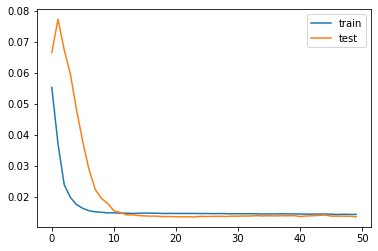

In [7]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()